# IMPORTS

In [932]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import binom
from IPython.display         import Image


import warnings
warnings.filterwarnings('ignore')

###--------- PANDAS - EXIBIR TODAS COLUNAS ----###

pd.set_option('display.max_columns', None)


###--------- ESTILIZAÇÃO DO NOTEBOOK ---------###

from IPython.core.display import display, HTML

# retira a margem do notebook
display(HTML("<style>.container { width:100% !important; }</style>"))

# font do texto markdown
display(HTML("<style>h1 { font-size:23px !important; }</style>"))
display(HTML("<style>h2 { font-size:20px !important; }</style>"))
display(HTML("<style>h3 { font-size:17px !important; }</style>"))
display(HTML("<style>h4 { font-size:16px !important; }</style>"))
display(HTML("<style>p { font-size:16px !important; }</style>"))

# tamanho da fonte da tabela
display(HTML("<style>th { font-size:15px !important; }</style>"))
display(HTML("<style>td { font-size:15px !important; }</style>"))

# font do codigo 
display(HTML("<style>span { font-size:16px !important; }</style>"))

# Introdução

Se você realizou uma boa coleta e limpeza de dados, e quer melhorar ainda mais a acurácia do seu modelo,<br>
ou talvez reduzir o seu tempo de treinamento, a Seleção de Features é o caminho ideal para você. 

Por meio desse processo é possível selecionar as variáveis mais relevantes para o seu modelo, eliminando <br>
as features que não agregam para a predição do problema.


# Por que selecionar features ?

**1-)** <b>Ganho de velocidade no treinamento do modelo</b>. Ao eliminar features não relevantes <br>
ocorre uma redução de dimensionalidade do problema, reduzindo o tempo de treinamento.

**2-)** <b>Melhora da performance do modelo</b>. Ao remover as features que não contribuem para a <br>
predição do modelo, tornamos o nosso modelo mais simples e, consequentemente, reduzimos o ruído dos <br>
nossos dados e a chance de ocorrer overfitting.

# Seleção de Features vs Redução de Dimensionalidade

A Seleção de Features consiste basicamente de selecionar e excluir features, sem alterar <br>
nenhuma delas, já a Redução de Dimensionalidade realiza transformações nas features para <br>
obter o mesmo efeito.

# Métodos de Seleção de Features

Os principais métodos de seleção de Features se agrupam em 3 tipos: <b>Filter Methods</b>, <b>Wrapper Methods</b> e <b>Embedded Methods</b>. 

## 1-) Filter Methods

Métodos de filtragem aplicam medidas estatísticas para atribuir uma pontuação para cada feature.

Exemplo: correlação de Pearson (no caso de variáveis contínuas).

## 2-) Wrapper Methods

São métodos que consideram a seleção de um conjunto de features como um problema de busca <br>
no qual diferentes combinações de features são preparadas, calculadas e comparadas <br>
com outras combinações de features.

Exemplo: Boruta

## 3-) Embedded Methods

São métodos que aprendem sobre quais features contribuem para a acurácia do modelo<br>
enquanto este está sendo criado.

Exemplo: Random Forest, XGBoost, LASSO.

# Algoritmo Boruta

O algoritmo Boruta é um Wrapper Method, que seleciona automaticamente as features mais relevantes <br>
para o seu modelo. Uma grande dificuldade de outros métodos de Seleção de Features é a definição <br>
de um limite para determinar qual feature é ou não relevante, esse algoritmo resolve isso para você.

Para entender melhor o porquê desse algoritmo ser um ótimo selecionador de features relevantes, <br> 
vamos implementá-lo do zero. Para fins didáticos vamos criar um cenário hipotético, com dados fictícios.

# Cenário Hipotético

Uma loja de acessórios para pets fez uma pesquisa com algumas pessoas para determinar quais <br>
delas estariam interessadas nos produtos dessa loja.

A partir da pesquisa foram obtidos os seguintes dados: 

**1-)** A quantidade de pets que a pessoa tem.

**2-)** O salário.

**3-)** A idade.

**4-)** O peso.

**5-)** A altura do pai.

**6-)** Se a pessoa apresenta interesse em comprar um produto para seu pet.

## Intuição

Seguindo a nossa intuição, há uma suspeita de que a <b>quantidade de pets</b> que a pessoa tem <br>
é uma informação relevante para o modelo, e que a <b>altura do pai da pessoa</b> não tem valor <br> 
nenhum para a nossa predição.

Vale lembrar que o nosso dataset contém apenas 5 features, mas o que aconteceria se tivéssemos <br>
dezenas, senão centenas de variáveis para analisar ? Certamente perderíamos a capacidade de intuir <br>
sobre todos os dados e surgiriam muitas dúvidas como:


**1-)** Quais das features são relevantes para a modelagem do problema ?

**2-)** Qual critério utilizar para selecionar as features mais relevantes ?

Vamos responder essas dúvidas com o algoritmo Boruta.

## Sobre os dados do problema

O dataset criado apresenta 5 features, contendo as informações de 15 pessoas entrevistadas.

A idade, o peso e a altura seguem o comportamento de uma distribuição normal e foram criadas <br>
de modo a não influenciarem na variável resposta, já a quantidade de pets e a faixa salarial <br>
foram construídas de modo a influenciar na variável target.

Portanto, ao final do treinamento do Boruta é esperado que a quantidade de pets e a faixa <br>
salarial sejam as features consideradas relevantes, e as demais descartadas.

### Detalhes acerca da criação do dataset

In [922]:
# Vamos assumir que a idade, o peso e a altura da mãe estão normalmente distribuídos
quant_pets = np.array([0,0,0,0,0,1,1,1,1,1,2,1,2,1,2])
faixa_salarial = np.array([1000,2000,2500,2600,3000,3001,4001,4001,4001,4601,4502,6071,5002,3001,4002])
faixa_salarial_mean = faixa_salarial.mean()
#y = np.array([0,0,0,1,1,0,0,0,1,1,0,0,0,1,1])
np.random.seed(57)
idade = np.random.normal(40, 12, 15)
peso =  np.random.normal(80, 10, 15)
altura_do_pai = np.random.normal(1.70, 0, 15)

# Convertendo a idade e o peso para números inteiros
quant_pets = quant_pets.astype(int)
faixa_salarial = faixa_salarial.astype(int)
idade = idade.astype(int)
peso = peso.astype(int)

# Arredondando para duas casas decimais
altura_do_pai = np.round( altura_do_pai, 2 )

x = pd.DataFrame({
                    'quant_pets': quant_pets,
                    'faixa_salarial': faixa_salarial,
                    'idade': idade,
                    'peso': peso,
                    'altura_do_pai': altura_do_pai
    })



y = np.zeros((15,)) + 1
y = y * np.array( x['quant_pets'] )
drop_salario = x['faixa_salarial'].apply(lambda x: 0 if x < faixa_salarial_mean else 1)
y = y * drop_salario
y = pd.Series(y, name='interesse')
y = y.apply(lambda x: 0 if x==0 else 1)
y

'''
print(y)

drop_quant_pets = x['quant_pets'].apply(lambda x: 0 if x < x['quant_pets'].mean() else 1)


y_mean = y.mean()
print(y)
y_mean
y = pd.Series(y, name='interesse')
y = y.apply(lambda x: 0 if x < y_mean else 1)
'''

"\nprint(y)\n\ndrop_quant_pets = x['quant_pets'].apply(lambda x: 0 if x < x['quant_pets'].mean() else 1)\n\n\ny_mean = y.mean()\nprint(y)\ny_mean\ny = pd.Series(y, name='interesse')\ny = y.apply(lambda x: 0 if x < y_mean else 1)\n"

### Conjunto de Features

In [923]:
x

,quant_pets,faixa_salarial,idade,peso,altura_do_pai
0,0,1000,38,78,1.7
1,0,2000,37,77,1.7
2,0,2500,19,75,1.7
3,0,2600,30,76,1.7
4,0,3000,58,79,1.7
5,1,3001,66,100,1.7
6,1,4001,8,75,1.7
7,1,4001,49,90,1.7
8,1,4001,60,86,1.7
9,1,4601,19,86,1.7


### Variável Resposta

In [867]:
y

0     0
1     0
2     0
3     0
4     0
5     0
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    0
14    1
Name: interesse, dtype: int64

# Algoritmo boruta Implementação

O algoritmo pode ser resumido em 6 etapas.

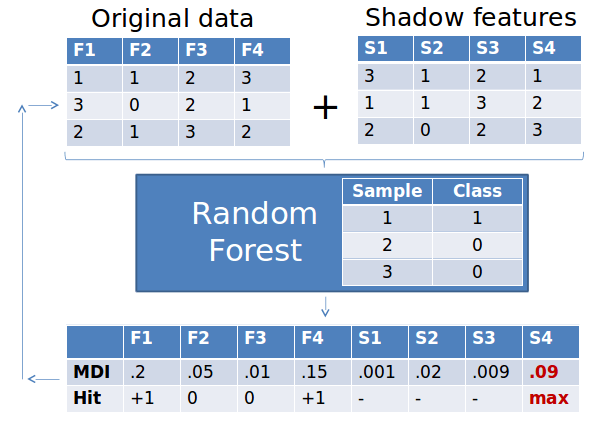

In [934]:
Image('img/boruta_image.png')

## 1-) Criação de shadow features

A partir do dataset inicial, criamos uma cópia para cada feature e a renomeamos com a palavra shadow.

In [858]:
num_of_features = x.shape[1]
x_shadow = x.copy()
x_shadow.columns = ['shadow_' + col_name for col_name in x.columns]
x_shadow

,shadow_quant_pets,shadow_faixa_salarial,shadow_idade,shadow_peso,shadow_altura_do_pai
0,0,1000,30,86,1.68
1,0,2000,30,79,1.40
2,0,2500,52,87,1.72
3,0,2600,25,63,1.79
4,0,3000,39,74,1.70
5,1,3001,43,83,1.58
6,1,4001,48,76,1.74
7,1,4001,45,84,1.67
8,1,4001,43,76,1.57
9,1,4601,45,75,1.55


## 2-) Embaralhamento das shadow features

Em cada shadow feature, realizamos um embaralhamento dos seus dados. Isso é <br>
feito para remover a correlação entre a shadow feature e a variável resposta. 

In [859]:
np.random.seed(21)
x_shadow = x_shadow.apply( lambda x: np.random.permutation(x) )
x_shadow = x_shadow.reset_index()
x_shadow.drop('index', axis=1, inplace=True)
x_shadow

,shadow_quant_pets,shadow_faixa_salarial,shadow_idade,shadow_peso,shadow_altura_do_pai
0,2,2000,23,83,1.57
1,1,2500,40,91,1.57
2,1,4002,25,76,1.72
3,2,3001,30,75,1.72
4,1,4001,45,85,1.40
5,0,2600,43,74,1.69
6,0,4001,39,76,1.67
7,2,6071,30,84,1.70
8,0,3000,60,87,1.79
9,1,1000,20,78,1.74


## 3-) Concatenação das features originais com as shadow features

In [860]:
x_merged = pd.concat( [x, x_shadow], axis=1 )
x_merged

,quant_pets,faixa_salarial,idade,peso,altura_do_pai,shadow_quant_pets,shadow_faixa_salarial,shadow_idade,shadow_peso,shadow_altura_do_pai
0,0,1000,30,86,1.68,2,2000,23,83,1.57
1,0,2000,30,79,1.40,1,2500,40,91,1.57
2,0,2500,52,87,1.72,1,4002,25,76,1.72
3,0,2600,25,63,1.79,2,3001,30,75,1.72
4,0,3000,39,74,1.70,1,4001,45,85,1.40
5,1,3001,43,83,1.58,0,2600,43,74,1.69
6,1,4001,48,76,1.74,0,4001,39,76,1.67
7,1,4001,45,84,1.67,2,6071,30,84,1.70
8,1,4001,43,76,1.57,0,3000,60,87,1.79
9,1,4601,45,75,1.55,1,1000,20,78,1.74


## 4-) Treinamento do modelo com o novo conjunto de dados (features originais + shadow features)

Será usado o algoritmo Random Forest para treinar o modelo, pois este algoritmo calcula <br>
a importância das features durante o seu treinamento, esse cálculo é baseado no método de Gini.


In [413]:
rf = RandomForestClassifier(random_state=42, max_depth=3)
rf.fit( x_merged, y )

RandomForestClassifier(max_depth=3, random_state=42)

In [ ]:
rf.feature_importances_

In [862]:
importance_table = pd.DataFrame([rf.feature_importances_], columns=x_merged.columns)
importance_table

,quant_pets,faixa_salarial,idade,peso,altura_do_pai,shadow_quant_pets,shadow_faixa_salarial,shadow_idade,shadow_peso,shadow_altura_do_pai
0,0.10343,0.353913,0.067622,0.045149,0.060671,0.036896,0.126197,0.050674,0.099266,0.056181


### Vamos obter a maior importância dentre as shadow features 

In [864]:
imp_feature_list = rf.feature_importances_
imp_original_feature_list = imp_feature_list[:len(x.columns)]
imp_shadow_feature_list = imp_feature_list[len(x.columns):]
print('O maior valor de importância dado a uma shadow feature foi: ' + str(np.round( imp_shadow_feature_list.max(), 4) ))

O maior valor de importância dado a uma shadow feature foi: 0.1262


## 5-) Avaliação da importância das features originais com as shadow features

Se a feature original apresentar importância maior que a maior importância das shadow features, ela teve um sucesso.

Caso contrário, ela teve um fracasso.

In [511]:
sucess_table = ( imp_original_feature_list > imp_shadow_feature_list.max() ).astype(int)
sucess_table

array([0, 1, 0, 0, 0])

## LOOP - repetição dos processos 2, 4 e 5

Para obter uma melhor precisão acerca da importância fornecida pelo algoritmo Random Forest,<br>
repetimos o processo por 20 vezes, sempre marcando os pontos.

## Algoritmo Completo

In [924]:
class borutaAlgorithm:
    
    def __init__(self, max_steps, x, y):
        self.max_steps = max_steps
        self.x = x
        self.y = y
        self.num_of_features = x.shape[1]
        self.seed = 21
        np.random.seed( self.seed )
    
    def creatingShadowFeatures(self, x):
        x_shadow = x.copy()
        x_shadow.columns = ['shadow_' + col_name for col_name in x.columns]      
        return x_shadow
        
    def shufflingShadowFeatures(self, x_merged ):
        x_merged.iloc[:, self.num_of_features:] = x_merged.iloc[:, self.num_of_features:].apply( lambda x: np.random.permutation(x), axis=0 )
        return x_merged
    
    def mergeOriginalAndShadowFeatures( self, x, x_shadow ):
        return pd.concat( [x, x_shadow], axis=1 )
            
    def training(self, x_merged, y, sucess_table):
        rf = RandomForestClassifier(random_state=42, max_depth=3)
        rf.fit( x_merged, y )
        imp_feature_list = rf.feature_importances_
        imp_original_feature_list = imp_feature_list[:len(x.columns)]
        imp_shadow_feature_list = imp_feature_list[len(x.columns):]
        #print(rf.feature_importances_)
        sucess_table = sucess_table + ( imp_original_feature_list > imp_shadow_feature_list.max() ).astype(int)

        return sucess_table
    
    def findBestFeatures(self):
        # creation of shadow features
        shadow_features = self.creatingShadowFeatures( self.x )
        # merge with the original features
        merged_data = self.mergeOriginalAndShadowFeatures( self.x, shadow_features )
        # creation of sucess_table, initially all zeros
        sucess_table = np.zeros((self.num_of_features,))
        
        for i in range( self.max_steps ):
            print('Step ' + str(i+1), end='\n')
            # shuffling the shadow features
            merged_data = self.shufflingShadowFeatures( merged_data )
            sucess_table = self.training( merged_data, self.y, sucess_table )
            
        return sucess_table

In [925]:
boruta = borutaAlgorithm(max_steps=20, x = x, y = y)
list_of_sucess = boruta.findBestFeatures()
print(list_of_sucess)
list_of_sucess = list_of_sucess.reshape((1,5))

df_of_sucess = pd.DataFrame(list_of_sucess, columns=[x.columns])
df_of_sucess

Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
[19. 20.  3. 11.  0.]


,quant_pets,faixa_salarial,idade,peso,altura_do_pai
0,19.0,20.0,3.0,11.0,0.0


# 6-) Decisão de manter ou excluir as features

Em cada iteração cada feature poderia ter ganhado das features shadow ou perdido para elas. Vamos supor <br>
que nós não temos nenhum conhecimento prévio acerca das features, logo há uma chance de 50% dela ganhar e 50% <br>
de perder.

Se a feature é de fato relevante ela irá ganhar com mais frequência, pois as features shadow são arbitrárias e sem <br>
correlação com a variável resposta.

Como nesse experimento só há duas possibilidades: ganhar ou perder, ele recebe o nome de Ensaio de Bernoulli, <br>
porém iteramos 20 vezes, ou seja, foram feitos 20 Ensaios de Bernoulli sucessivos, isso caracteriza a <br>
distribuição binomial.

Uma distribuição binomial com n=20 e p=0.5 possui a seguinte cara:

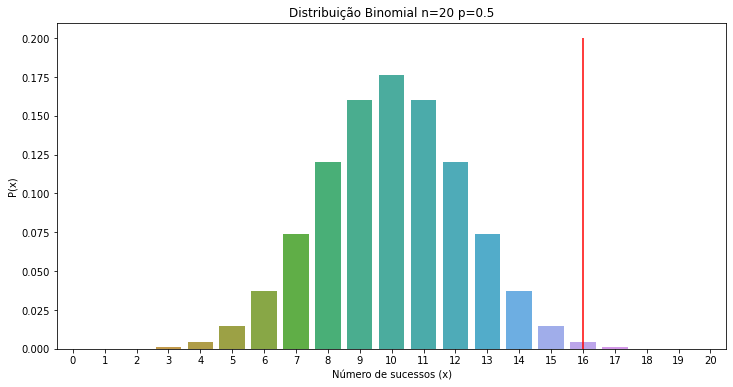

In [947]:
n = 20
p = 0.5

binomial_values = list( np.arange(n+1) )
dist = [ binom.pmf(val, n, p) for val in binomial_values]

plt.figure(figsize=(12,6))
plt.title('Distribuição Binomial n=20 p=0.5')
plt.xlabel('Número de sucessos (x)')
plt.ylabel('P(x)')
plt.vlines(16,0,0.2, color='red')
sns.barplot(binomial_values, dist);

Sendo X ~ Bin(n,p) uma variável aleatória que representa o número de sucessos obtidos

**P(X <= 3) = 0.001288 < 0,5%**

**P(X >= 17) = 0.001288 < 0,5%**

In [928]:
df_of_sucess

,quant_pets,faixa_salarial,idade,peso,altura_do_pai
0,19.0,20.0,3.0,11.0,0.0


In [ ]:
prob = 0
for i in range(4):
    prob = prob + dist[i]
prob

# Teste de Hipótese

Vamos realizar um teste de hipótese de uma calda, utilizando **pvalor = 0.005**

**H0: A feature quant_pets não apresenta relevância para o modelo (p <= 0.5)**

**H1: A feature quant_pets apresenta relevância para o modelo (p > 0.5)**

A região crítica, que neste exemplo contém 0,5% dos dados, possui seu início em x=16 e estende-se até
x=20.

Como a feature quant_pets apresentou 19 sucessos, ela está localizada na região crítica, e portanto <br>
há evidência para rejeitarmos H0, ou seja, há evidência para considerarmos a feature quant_pets como <br>
relevante para o modelo, dizemos isso com um intervalo de confiança de 99,5%.

# Conclusão

As Features consideradas **RELEVANTES** são: **quant_pets** e **faixa_salarial**

As Features consideradas **NÃO RELEVANTES** são: **idade** e **altura_do_pai**

# Bibliografia

Package 'Boruta' (R) - https://cran.r-project.org/web/packages/Boruta/Boruta.pdf
 
Boruta (Python) - https://pypi.org/project/Boruta/

An introduction to feature selection - https://machinelearningmastery.com/an-introduction-to-feature-selection/
 
Boruta Explained Exactly How You Wished Someone Explained to You - https://towardsdatascience.com/boruta-explained-the-way-i-wish-someone-explained-it-to-me-4489d70e154a

Gini Impurity in decision tree - https://www.geeksforgeeks.org/gini-impurity-and-entropy-in-decision-tree-ml/